In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, TimeSeriesSplit

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer,
    Dense,
    Input,
    Concatenate,
    GlobalAveragePooling1D,
    Dropout,
    LayerNormalization,
    Conv1D
)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [ ]:
data_path = 'data.csv'
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.shape

(738, 9)

In [ ]:
df = df.drop(columns=['date'])
df['tests'] = df['tests'].replace(to_replace=0, method='bfill')

df = df.drop(columns=['new_deaths', 'people_hospitalised', 'occupied_ventilators', 'quarantined_people'])
columns = df.columns

scaler = MinMaxScaler()
df[columns] = scaler.fit_transform(df[columns])
df.head()

<ipython-input-29-7827ddfc039f>:2: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['tests'] = df['tests'].replace(to_replace=0, method='bfill')


,tests,new_recoveries,active_cases,new_cases
0,0.000000,0.0,0.000000,0.000000
1,0.000000,0.0,0.000001,0.000017
2,0.000373,0.0,0.000001,0.000000
3,0.000857,0.0,0.000006,0.000069
4,0.001524,0.0,0.000007,0.000017


In [ ]:
seq_len = 28
num_features = 4

# Arrange data into X and y
X, y = [], []
data = df.values
for i in range(seq_len, len(data)):
  X.append(data[i-seq_len:i])
  y.append(data[:, num_features-1][i])
X, y = np.array(X), np.array(y)

In [ ]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)

    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

In [ ]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

    self.key = Dense(self.d_k,
                     input_shape=input_shape,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='glorot_uniform')

    self.value = Dense(self.d_v,
                       input_shape=input_shape,
                       kernel_initializer='glorot_uniform',
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)

    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out

In [ ]:
class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))

    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7
    self.linear = Dense(input_shape[0][-1],
                        input_shape=input_shape,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

In [ ]:
class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1)
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config

In [ ]:
def calculate_index_of_agreement(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((np.abs(y_pred - np.mean(y_true)) + np.abs(y_true - np.mean(y_true))) ** 2)
    index_of_agreement = 1 - (numerator / denominator)
    return index_of_agreement

# Define helper functions for evaluation
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    index_of_agreement = calculate_index_of_agreement(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, r2, index_of_agreement, mape

def print_evaluation_results_extended(mse_scores, mae_scores, r2_scores, index_of_agreement_scores, mape_scores):
    print('---------------------------')
    print('Average MSE:', np.mean(mse_scores))
    print('Average MAE:', np.mean(mae_scores))
    print('Average R^2:', np.mean(r2_scores))
    print(f"Mean Index of Agreement: {np.mean(index_of_agreement_scores)}")
    print(f"MAPE: {np.mean(mape_scores)}")
    print('---------------------------')

In [ ]:
from keras.metrics import MeanSquaredError

# Define the custom objects including 'mse'
custom_objects = {
    'Time2Vector': Time2Vector,
    'SingleAttention': SingleAttention,
    'MultiAttention': MultiAttention,
    'TransformerEncoder': TransformerEncoder,
    'mse': MeanSquaredError(),  # Add MeanSquaredError to custom objects
}

# Load the model with the custom objects
model = tf.keras.models.load_model(
    '/content/Multivariate-Time-Series-Forecasting-Using-Transformers/model.hdf5',
    custom_objects=custom_objects
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/layer_normalization.py:122: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Evaluate the final model on the test set
y_pred = model.predict(X)
mse, mae, r2, index_of_agreement, mape = evaluate_model(y, y_pred)

print('Final Model Evaluation Results:')
print_evaluation_results_extended(mse, mae, r2, index_of_agreement, mape)

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step
Final Model Evaluation Results:
---------------------------
Average MSE: 0.005460281331090198
Average MAE: 0.03166819058853877
Average R^2: 0.8368945113800719
Mean Index of Agreement: 0.3870636343779291
MAPE: 0.31179077633416047
---------------------------


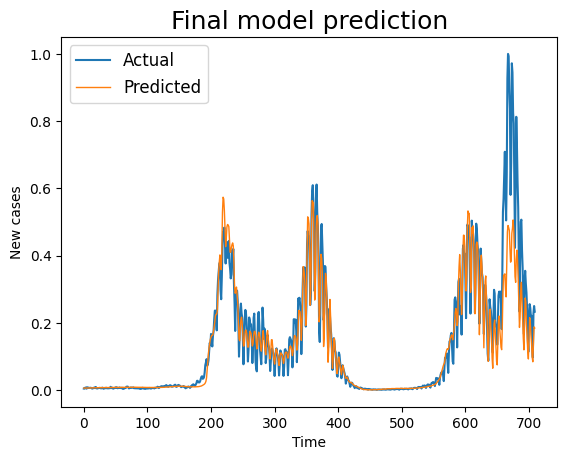

In [ ]:
# Create subplots for results
ax = plt.subplot()

# Plot test data results
ax.plot(y.flatten(), label='Actual')
ax.plot(y_pred.flatten(), linewidth=1, label='Predicted')
ax.set_title("Final model prediction", fontsize=18)
ax.set_xlabel('Time')
ax.set_ylabel('New cases')
ax.legend(loc="best", fontsize=12)

# Display the plot
plt.show()